In [1]:
# ------------------------------ Packages & Files ------------------------------
from pathlib import Path

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn.objects as so
from plotly.subplots import make_subplots

import ipywidgets as widgets
from IPython.display import display, HTML

from ppa_analysis import user_inputs, advanced_settings, hybrid, import_data,\
    bill_calc, battery, firming_contracts, load_flex, helper_functions, charts

INFO: Using Python-MIP package version 1.16rc0


In [4]:
# ------------------------------ Initialise the input collector ----------------
input_collector = user_inputs.launch_input_collector()

/Users/elliekallmier/Desktop/RA_Work/247/247_ppa/ppa_analysis
data_caches/yearly_data_files


Dropdown(description='Year:', options=('2020', '2021'), value='2020')

Dropdown(description='Generator region:', options=('QLD1', 'NSW1', 'VIC1', 'SA1', 'TAS1'), value='QLD1')

Dropdown(description='Load region:', options=('QLD1', 'NSW1', 'VIC1', 'SA1', 'TAS1'), value='QLD1')

Dropdown(description='Load data file:', options=('(57) Sewerage treatment FN.csv', '(54) Office building FN.cs…

SelectMultiple(description='Generators:', index=(0, 1, 2, 3), options=('CSPVPS1: PHOTOVOLTAIC FLAT PANEL', 'CO…

Dropdown(description='Contract type:', options=('Pay as Produced', 'Pay as Consumed', 'Shaped', 'Baseload', '2…

Dropdown(description='Firming contract type:', options=('Wholesale exposed', 'Partially wholesale exposed', 'R…

Dropdown(description='Settlement period:', options=('Y', 'M', 'Q'), value='Y')

BoundedFloatText(value=100.0, description='Contract amount (%):', max=1000.0)

FloatText(value=100.0, description='Strike price ($/MW/h):')

FloatText(value=35.0, description='LGC buy price ($/MW/h):')

FloatText(value=20.0, description='LGC sell price ($/MW/h):')

FloatText(value=25.0, description='Short fall penalty ($/MW/h):')

BoundedFloatText(value=85.0, description='Guaranteed percentage (%):')

FloatText(value=0.0, description='Floor price ($/MW/h):')

FloatText(value=65.0, description='Excess price ($/MW/h):')

BoundedFloatText(value=1.0, description='Indexation (%):')

Dropdown(description='Index period:', options=('Y',), value='Y')

Dropdown(description='Redefine period:', index=2, options=('Y', 'Q', 'M'), value='M')

BoundedFloatText(value=90.0, description='Matching percentile:')

FloatText(value=300.0, description='Exposure upper bound ($/MW/h):')

FloatText(value=20.0, description='Exposure lower bound ($/MW/h):')

Dropdown(description='Time series interval:', options=('60',), value='60')

Dropdown(description='Generator data set:', options=('GenCost 2018 Low',), value='GenCost 2018 Low')

In [5]:
generator_data_editor = user_inputs.launch_generator_data_editor(input_collector)

Output()

In [6]:
tariff_collector = user_inputs.tariff_options_collector(input_collector)
extra_charges_collector = user_inputs.launch_extra_charges_collector()

Dropdown(description='Tariff name:', options=('ELTOUDT1 ToU Demand East', 'ELTOUDT2 ToU Demand East', 'ELTOUDT…

FloatText(value=0.06, description='Peak rate ($/kWh):')

FloatText(value=0.06, description='Shoulder rate ($/kWh):')

FloatText(value=0.04, description='Off-Peak rate ($/kWh):')

FloatText(value=0.0, description='Retailer demand charge ($/kVA/day):')

FloatText(value=2.0, description='Meter Provider/Data Agent Charges ($/Day):')

FloatText(value=6.0, description='Other Meter Charges ($/Day):')

FloatText(value=0.8, description='LREC Charge ($/kWh):')

FloatText(value=0.4, description='SREC Charge ($/kWh):')

FloatText(value=0.2, description='State Environment Charge ($/kWh):')

FloatText(value=0.036, description='AEMO Participant Charge ($/kWh):')

FloatText(value=0.018, description='AEMO Ancillary Services Charge ($/kWh):')

FloatText(value=0.0, description='Other Variable Charge 1 ($/kWh):')

FloatText(value=0.0, description='Other Variable Charge 2 ($/kWh):')

FloatText(value=0.0, description='Other Variable Charge 3 ($/kWh):')

FloatText(value=0.0, description='Total GST ($/Bill):')

FloatText(value=0.0, description='Other Fixed Charge 1 ($/Bill):')

FloatText(value=0.0, description='Other Fixed Charge 2 ($/Bill):')

In [5]:
# Fetch and unpack tariff and extra charge inputs
tariff_name = tariff_collector['tariff_name'].value

def format_other_charges(
        extra_charges_collector:dict
) -> dict:
    other_charges = { 
        "Customer Type": "Commercial",
        "Energy Charges": {
            "Peak Rate": {
            "Unit": "c/kWh",
            "Value": extra_charges_collector['peak_rate'].value
            },
            "Shoulder Rate": {
            "Unit": "c/kWh",
            "Value": extra_charges_collector['shoulder_rate'].value
            },
            "Off-Peak Rate": {
            "Unit": "c/kWh",
            "Value": extra_charges_collector['off_peak_rate'].value
            },
            "Retailer Demand Charge": {
            "Unit": "c/kVA/day",
            "Value": extra_charges_collector['retailer_demand_charge'].value
            }
        },
        "Metering Charges": {
            "Meter Provider/Data Agent Charges": {
            "Unit": "$/Day",
            "Value": extra_charges_collector['meter_provider_charge'].value
            },
            "Other Meter Charges": {
            "Unit": "$/Day",
            "Value": extra_charges_collector['other_meter_charge'].value
            }
        },
        "Environmental Charges": {
            "LREC Charge": {
            "Unit": "c/kWh",
            "Value": extra_charges_collector['lrec_charge'].value
            },
            "SREC Charge": {
            "Unit": "c/kWh",
            "Value": extra_charges_collector['srec_charge'].value
            },
            "State Environment Charge": {
            "Unit": "c/kWh",
            "Value": extra_charges_collector['state_env_charge'].value
            }
        },
        "AEMO Market Charges": {
            "AEMO Participant Charge": {
            "Unit": "c/kWh",
            "Value": extra_charges_collector['participant_charge'].value
            },
            "AEMO Ancillary Services Charge": {
            "Unit": "c/kWh",
            "Value": extra_charges_collector['ancillary_services_charge'].value
            }
        },
        "Other Variable Charges": {
            "Other Variable Charge 1": {
            "Unit": "$/kWh",
            "Value": extra_charges_collector['other_charge_one'].value
            },
            "Other Variable Charge 2": {
            "Unit": "$/kWh",
            "Value": extra_charges_collector['other_charge_two'].value
            },
            "Other Variable Charge 3": {
            "Unit": "$/kWh",
            "Value": extra_charges_collector['other_charge_three'].value
            }
        },
        "Other Fixed Charges": {
            "Total GST": {
            "Unit": "$/Bill",
            "Value": extra_charges_collector['total_gst'].value
            },
            "Other Fixed Charge 1": {
            "Unit": "$/Bill",
            "Value": extra_charges_collector['other_fixed_charge_one'].value
            },
            "Other Fixed Charge 2": {
            "Unit": "$/Bill",
            "Value": extra_charges_collector['other_fixed_charge_two'].value
            }
        }
    }

    return other_charges

In [6]:
# ------------------- Unpack LCOE Inputs -------------------------

# Calculate LCOE from user inputs/predetermined values
# Function takes in the  generator LCOE info dictionary, and calculates LCOE
# for only one generator with each call.
# Returns LCOE value in $/MW
def calculate_lcoe(
    generator_info:dict[str:object]        
) -> float:
    
    # Baseline assumptions:
    discount_rate = advanced_settings.DISCOUNT_RATE

    capital = generator_info['capital'].value*1000
    construction_years = generator_info['construction_time'].value
    economic_life = generator_info['economic_life'].value
    fixed_om = generator_info['fixed_om'].value
    variable_om = generator_info['variable_om'].value
    capacity_factor = generator_info['capacity_factor'].value

    first_capital_sum = (capital*(1+discount_rate)**construction_years * discount_rate * (1+discount_rate)**economic_life) / (((1+discount_rate)**economic_life)-1)/(8760*capacity_factor)

    op_and_main = variable_om * ((fixed_om*1000)/(8760*capacity_factor))

    lcoe = first_capital_sum + op_and_main

    return lcoe


# ----- Fetch inputs and set up info_dict data to pass to later functions:
def get_all_lcoes(
        generator_data_editor:dict[str:dict[str:object]]
) -> dict[str:float]:
    all_generator_lcoes = {}
    for gen, gen_info in generator_data_editor.items():
        if gen != 'out':
            gen_lcoe = calculate_lcoe(gen_info)
            all_generator_lcoes[gen] = gen_lcoe
    
    return all_generator_lcoes


In [7]:
# Maybe this function is where the load gets pulled in, all the other data collecting
# functions get called etc

def collect_and_combine_data(
        input_collector:dict
) -> pd.DataFrame:    
    # ----------------------------- Unpack user input ------------------------------
    year_to_load_from_cache = input_collector['year'].value
    year_to_load = int(year_to_load_from_cache)
    GENERATOR_REGION = input_collector['generator_region'].value
    LOAD_REGION = input_collector['load_region'].value
    generators = list(input_collector['generators'].value)

    # ------------------- Get Load Data --------------------
    # if using preset data, use these hard coded values:
    LOAD_DATA_DIR = 'data_caches/c_and_i_customer_loads'
    load_filename = input_collector['load_data_file'].value
    filepath = LOAD_DATA_DIR + '/' + load_filename
    LOAD_DATETIME_COL_NAME = 'TS'
    LOAD_COL_NAME = 'Load'
    DAY_FIRST = True

    # Units are definitely a question.
    load_data, start_date, end_date = import_data.get_load_data(filepath, LOAD_DATETIME_COL_NAME, LOAD_COL_NAME, DAY_FIRST)
    load_data = load_data / 1000    # convert to MWh
    load_data = load_data[
        (load_data.index >= f'{year_to_load}-01-01 00:00:00') & 
        (load_data.index < f'{year_to_load+1}-01-01 00:00:00')
    ]

    # else: TODO add another option here if users want to load in their own data

    # ----------------------------- Get Generation Data ----------------------------
    gen_data_file = (
        advanced_settings.YEARLY_DATA_CACHE / 
        f'gen_data_{year_to_load_from_cache}.parquet'
    )
    gen_data = import_data.get_preprocessed_gen_data(
        gen_data_file, [GENERATOR_REGION]
    )
    gen_data = gen_data[generators]

    # --------------------------- Get Emissions Data -------------------------------
    emissions_data_file = (
        advanced_settings.YEARLY_DATA_CACHE / 
        f'emissions_data_{year_to_load_from_cache}.parquet'
    )
    emissions_intensity = import_data.get_preprocessed_avg_intensity_emissions_data(
        emissions_data_file, [LOAD_REGION, GENERATOR_REGION]
    )

    # ------------------------ Get Wholesale Price Data ----------------------------
    price_data_file = (
        advanced_settings.YEARLY_DATA_CACHE / 
        f'price_data_{year_to_load_from_cache}.parquet'
    )
    price_data = import_data.get_preprocessed_price_data(
        price_data_file, [LOAD_REGION, GENERATOR_REGION]
    )

    combined_data = pd.concat([load_data, gen_data, price_data, emissions_intensity], axis='columns')

    FIRMING_CONTRACT_TYPE = input_collector['firming_contract_type'].value
    EXPOSURE_BOUND_UPPER = input_collector['exposure_upper_bound'].value
    EXPOSURE_BOUND_LOWER = input_collector['exposure_lower_bound'].value
    RETAIL_TARIFF_DETAILS = {}

    # Add the firming details:
    combined_data = firming_contracts.choose_firming_type(
        FIRMING_CONTRACT_TYPE, combined_data, [LOAD_REGION], EXPOSURE_BOUND_UPPER, EXPOSURE_BOUND_LOWER, RETAIL_TARIFF_DETAILS
    )

    return combined_data

In [8]:
# At the moment: this is all assuming the use of sample load data stored with the tool
gen_info = get_all_lcoes(generator_data_editor)
combined_data = collect_and_combine_data(input_collector)

# Had an issue with first row containing a few NaN values causing problems for 
# the firming column addition. But just using dropna without checks not a safe bet
# necessarily...
combined_data = combined_data.dropna(how='any', axis='rows')

Some missing data found. Filled with zeros.



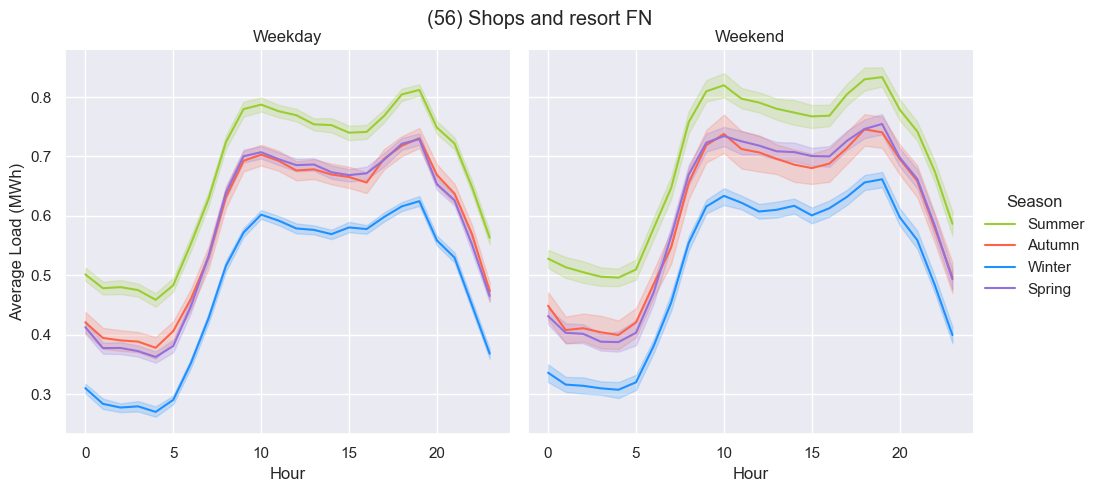

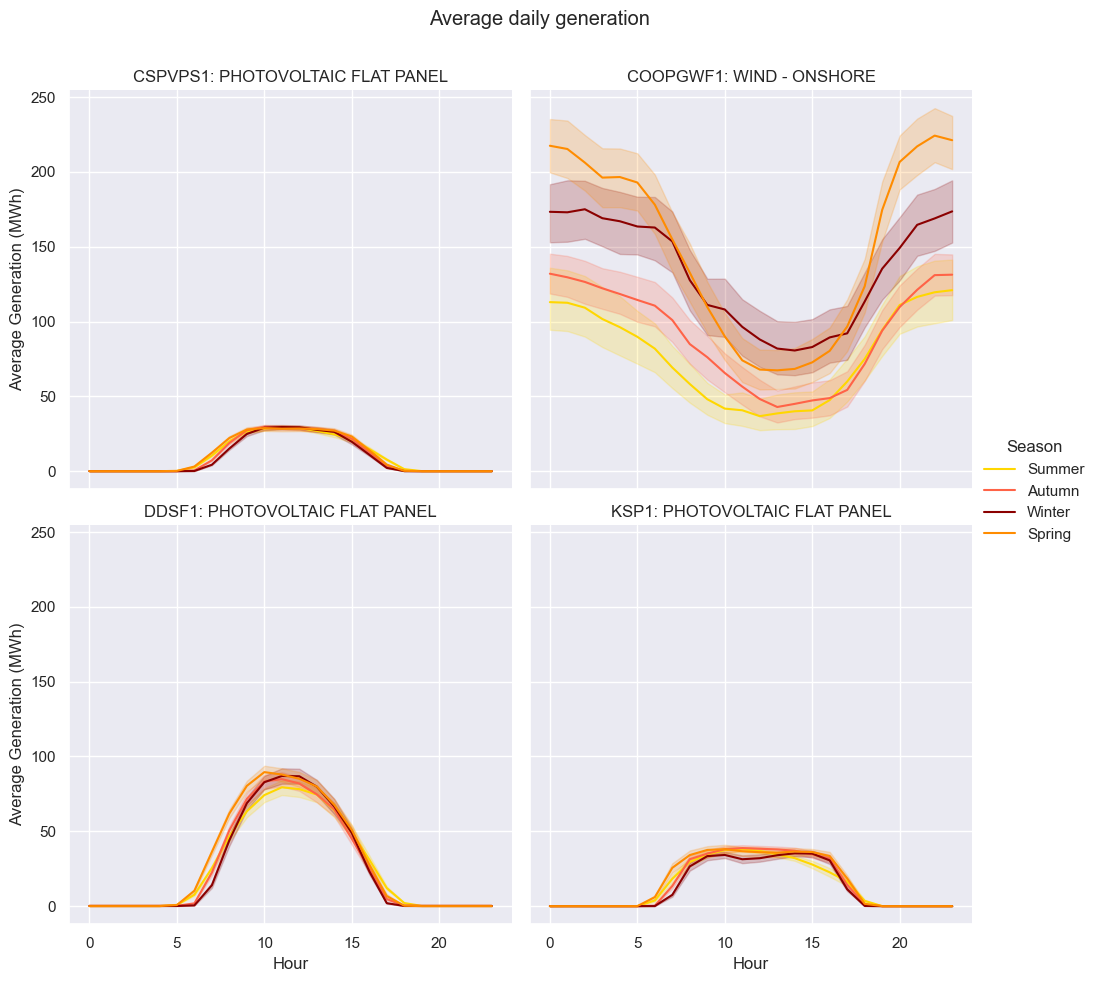

In [9]:
# Characteristic charts:
import seaborn as sns
import matplotlib.pyplot as plt

charts.plot_avg_seasonal_load(combined_data, input_collector)
charts.plot_avg_seasonal_generation(combined_data, input_collector, generator_data_editor)

In [10]:
# Now calculate the hybrid percentage here:
opt_hybrid, percentages = hybrid.create_hybrid_generation(
    input_collector['contract_type'].value, 
    input_collector['redefine_period'].value,  
    input_collector['contract_amount'].value, 
    combined_data, 
    input_collector['load_region'].value, 
    gen_info, 
    input_collector['time_series_interval'].value, 
    input_collector['matching_percentile'].value
)

combined_data['Contracted Energy'] = opt_hybrid['Contracted Energy'].copy()
combined_data['Hybrid'] = opt_hybrid['Hybrid'].copy()
combined_data['Delivered Hybrid'] = np.minimum(
    combined_data['Contracted Energy'], combined_data['Hybrid']
)


In [11]:
# Now calculate the hybrid percentage here:
contract_type = input_collector['contract_type'].value
redefine_period = input_collector['redefine_period'].value
contract_amount = input_collector['contract_amount'].value
load_region = input_collector['load_region'].value
time_series_interval = input_collector['time_series_interval'].value
matching_percentile = input_collector['matching_percentile'].value

opt_hybrid, percentages = hybrid.create_hybrid_generation(
    contract_type, 
    redefine_period,  
    contract_amount, 
    combined_data, 
    load_region, 
    gen_info, 
    time_series_interval, 
    matching_percentile
)

combined_data['Hybrid'] = opt_hybrid['Hybrid'].copy()
combined_data['Contracted Energy'] = opt_hybrid['Contracted Energy'].copy()

In [13]:
import copy
from datetime import timedelta
from sunspot_bill_calculator import bill_calculator, convert_network_tariff_to_retail_tariff, add_other_charges_to_tariff
from pprint import pprint

# Gets the 'chunk' of load data for one settlement period
def get_load_data_chunk(
    load_data:pd.DataFrame, # df that contains the load data in a column labelled 'Load', and has a DateTimeIndex labelled 'TS'
    end_date:pd.Timestamp    # timestamp from a datetime index that denotes the end of the chunk
) -> tuple[pd.DataFrame, pd.DataFrame]:
    
    end_date_plus_one_day = end_date + timedelta(days=1)
    chunk = load_data[load_data.index <= end_date_plus_one_day].copy()
    remainder = load_data[load_data.index > end_date_plus_one_day].copy()
    
    return chunk, remainder

# Simple wrapper to just load in and return a list of all the large commercial tariffs
def get_all_tariffs() -> list:
    all_tariffs = helper_functions.read_json_file(advanced_settings.COMMERCIAL_TARIFFS_FN)
    all_tariffs = all_tariffs[0]['Tariffs']
    return all_tariffs

# chunk up the data, run the bill calculator and return a calculated bill at 
# the specified settlement period:
def tariff_bill_calculator(
        load_and_gen_data:pd.DataFrame,
        input_collector:dict,
        tariff_collector:dict,
        extra_charges_collector:dict
):
    # Resample the datetime index by the settlement period to help chunk up the
    # load data to calculate periodic bills:
    settlement_period = input_collector['settlement_period'].value
    resampled_load_index = load_and_gen_data.copy().resample(settlement_period).sum(numeric_only=True)
    resampled_load_index = resampled_load_index.index


    # Load in all the tariffs and find the selected tariff (network charges):
    all_tariffs = get_all_tariffs()
    selected_tariff_name = tariff_collector['tariff_name'].value
    selected_tariff = {}
    for tariff in all_tariffs:
        if tariff['Name'] == selected_tariff_name:
            selected_tariff = copy.deepcopy(tariff)

    # Load in and format all other_charges (retail charges):
    other_charges = format_other_charges(extra_charges_collector)
    retail_copy = copy.deepcopy(selected_tariff)
    retail_tariff = convert_network_tariff_to_retail_tariff(add_other_charges_to_tariff(retail_copy, other_charges))
    # pprint(retail_tariff)
    
    network_tariff = convert_network_tariff_to_retail_tariff(selected_tariff)
    # pprint(network_tariff)
    tariff_bill_results = pd.DataFrame(index=resampled_load_index, columns=['Network Bill ($)','Retail Bill ($)', 'Total ($)'])

    # Separate out the firming energy as a new column (to apply retail charges onto):
    remainder = load_and_gen_data.copy()
    remainder['Firming Energy'] = (load_and_gen_data['Load'] - \
                                   load_and_gen_data['Contracted Energy']).clip(lower=0.0)
    for end_date in resampled_load_index:
        load_chunk, remainder = get_load_data_chunk(remainder, end_date)
        load_chunk = load_chunk[['Load', 'Firming Energy']] * 1000  # convert the load data to kWh from MWh
        load_chunk = load_chunk.reset_index()

        # network charges applied to all load:
        network_load = load_chunk[['DateTime','Load']].copy()\
            .rename(columns={'DateTime':'TS', 'Load':'kWh'})
        print(end_date)
        network_bill = bill_calculator(network_load, network_tariff, None, False)
       
        tariff_bill_results.loc[end_date, 'Network Bill ($)'] = network_bill['Retailer']['Bill'][0]

        firming_energy = load_chunk[['DateTime','Firming Energy']].copy()\
            .rename(columns={'DateTime':'TS', 'Firming Energy':'kWh'})
        
        retail_bill = bill_calculator(firming_energy, retail_tariff, None, False)
        tariff_bill_results.loc[end_date, 'Retail Bill ($)'] = retail_bill['Retailer']['Bill'][0]
        
    print(tariff_bill_results)
    return

tariff_bill_calculator(combined_data, input_collector, tariff_collector, extra_charges_collector)

2020-01-31 00:00:00
2020-02-29 00:00:00
2020-03-31 00:00:00
2020-04-30 00:00:00
2020-05-31 00:00:00
2020-06-30 00:00:00
2020-07-31 00:00:00
2020-08-31 00:00:00
2020-09-30 00:00:00
2020-10-31 00:00:00
2020-11-30 00:00:00
2020-12-31 00:00:00
           Network Bill ($) Retail Bill ($) Total ($)
DateTime                                             
2020-01-31     58149.513684    15319.102968       NaN
2020-02-29     51259.322556    13175.180633       NaN
2020-03-31     51667.476983     14145.56485       NaN
2020-04-30     49775.407661    13800.431922       NaN
2020-05-31     43778.755611    13561.251372       NaN
2020-06-30     40679.751616    15478.797193       NaN
2020-07-31     41492.103328    14246.881188       NaN
2020-08-31     43340.198995    14180.397268       NaN
2020-09-30      45535.82586    13363.384374       NaN
2020-10-31      49160.33806    14056.814331       NaN
2020-11-30      52301.73427    13870.386076       NaN
2020-12-31     41671.878143    12963.798747       NaN


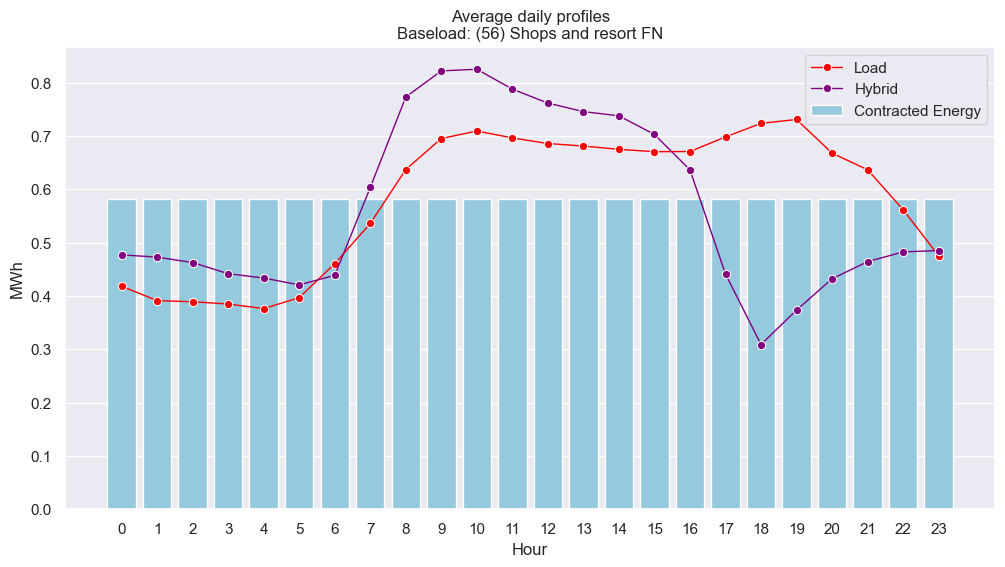

In [29]:
charts.plot_contract_samples(combined_data,input_collector,['Load'])

In [26]:
bill = bill_calc.calculate_bill(
    volume_and_price=combined_data, 
    settlement_period=input_collector['settlement_period'].value, 
    contract_type=input_collector['contract_type'].value, 
    load_region=input_collector['load_region'].value, 
    strike_price=input_collector['strike_price'].value, 
    lgc_buy_price=input_collector['lgc_buy_price'].value, 
    lgc_sell_price=input_collector['lgc_sell_price'].value, 
    shortfall_penalty=input_collector['shortfall_penalty'].value, 
    guaranteed_percent=input_collector['guaranteed_percent'].value, 
    excess_price=input_collector['excess_price'].value, 
    indexation=input_collector['indexation'].value, 
    index_period=input_collector['index_period'].value, 
    floor_price=input_collector['floor_price'].value
)

wholesale_bill = bill_calc.calculate_wholesale_bill(
    df=combined_data,
    settlement_period=input_collector['settlement_period'].value,
    load_region=input_collector['load_region'].value,
    lgc_buy_price=input_collector['lgc_buy_price'].value
)

In [27]:
bill

,PPA Value,PPA Settlement,PPA Final Cost,Firming Costs,Revenue from on-sold RE,Revenue from excess LGCs,Cost of shortfall LGCs,Shortfall Payments Received,Total
DateTime,,,,,,,,,
2020-01-31,53839.591843,19152.513778,53824.875517,3113.946419,-2756.012853,-1599.195797,0.0,-7244.235101,45339.378184
2020-02-29,44466.132962,20765.389452,44466.132962,2478.842233,-2623.277041,-1320.776227,0.0,-5212.083773,37788.838155
2020-03-31,46172.839458,27205.288622,46073.043018,2005.255529,-2776.875188,-1371.470479,0.0,-3509.301329,40420.651550
2020-04-30,46955.839826,29723.475365,46920.502855,1730.160267,-2851.202800,-1394.727916,0.0,-4294.908574,40109.823832
2020-05-31,37809.882112,24956.626176,36628.854561,1116.040913,-2831.430421,-1123.065805,0.0,-1589.349329,32201.049919
2020-06-30,35670.245335,23562.361119,35466.411159,1437.188699,-2762.680254,-1059.512238,0.0,-1913.703532,31167.703833
2020-07-31,35731.842727,22038.705791,35563.351760,1777.491166,-2901.768241,-1061.341863,0.0,-1551.005361,31826.727462
2020-08-31,36683.785290,24648.193718,35709.107230,1306.085922,-3071.237797,-1089.617385,0.0,-1638.540705,31215.797267
2020-09-30,39776.242786,28116.294296,38892.504365,1162.337698,-2911.362785,-1181.472558,0.0,-1231.841972,34730.164748


In [28]:
wholesale_bill

,Wholesale Cost,LGC Cost,Total
DateTime,,,
2020-01-31,35791.697482,18657.284302,54448.981784
2020-02-29,24351.538141,15409.055977,39760.594118
2020-03-31,19294.958383,16000.488921,35295.447305
2020-04-30,17414.796610,16271.825682,33686.622292
2020-05-31,11330.126537,13102.434395,24432.560932
2020-06-30,11982.672688,12360.976106,24343.648794
2020-07-31,13707.100111,12382.321737,26089.421848
2020-08-31,10691.526111,12712.202823,23403.728934
2020-09-30,10568.304654,13783.846510,24352.151164


In [30]:
small_bill = bill[['PPA Final Cost', 'Firming Costs', 'Revenue from on-sold RE', 'Revenue from excess LGCs', 'Cost of shortfall LGCs', 'Shortfall Payments Received']].copy()

In [ ]:
small_bill_with_wholesale = small_bill.copy()
small_bill_with_wholesale['Wholesale Total'] = wholesale_bill['Total'].copy()

# Make a bar plot for each settlement period

In [35]:
colours = {
    'Pay as Produced' : ['dodgerblue', 'lightskyblue', 'blue'], 
    'Pay as Consumed' : ['gold', 'goldenrod', 'orange'], 
    '24/7' : ['darkviolet', 'indigo', 'purple'], 
    'Baseload' : ['limegreen', 'yellowgreen', 'green'], 
    'Shaped' : ['orange', 'orangered', 'firebrick']
}

column_order = ['PPA Final Cost', 'Firming Costs', 'Revenue from on-sold RE', 'Revenue from excess LGCs', 'Cost of shortfall LGCs', 'Shortfall Payments Received', 'Total']

fig_w = go.Figure()

costs_waterfall = small_bill.copy()
costs_waterfall = costs_waterfall.resample('Y').sum(numeric_only=True)
costs_waterfall['Total'] = None
costs_waterfall['Year'] = costs_waterfall.index.year
costs_waterfall = costs_waterfall.set_index('Year', drop=True)

costs_waterfall = costs_waterfall.T
costs_waterfall['Measure'] = np.where(costs_waterfall.index == 'Total', 'total', 'relative')
costs_waterfall['Category'] = costs_waterfall.index
costs_waterfall = costs_waterfall.reset_index(drop=True)

costs_waterfall = costs_waterfall.melt(id_vars=['Category', 'Measure'])
colour = ['yellowgreen', 'orangered', 'lightskyblue',]

fig_w.add_trace(
    go.Waterfall(
        name = '', 
        orientation = "v",
        measure = costs_waterfall['Measure'],
        x = [costs_waterfall['Year'], costs_waterfall['Category']],
        y = costs_waterfall['value'],
        connector = {"line":{"color":"rgb(63, 63, 63)", "width":1}},
            # set colors for different types of bars
            # see https://plotly.com/python/waterfall-charts/#setting-marker-size-and-color
        decreasing = {"marker":{"color":colour[0]}},
        increasing = {"marker":{"color":colour[1]}},
        totals = {"marker":{"color":colour[2], "line":{"color":colour[2], "width":2}}}
    )
)

fig_w.update_layout(
    title = f"Cashflow",
    # showlegend = True,
    waterfallgroupgap = 0.25,
    height=800,
    width=1000,
    yaxis_title='$',
    xaxis=dict(showgrid=True, gridwidth=0.1, gridcolor='white')
)
# fig_w.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='white')
# fig_w.update_xaxes(nticks=20)

fig_w.show()

## Add a behind-the-meter battery:

In [15]:
battery_input_collector = user_inputs.launch_battery_input_collector()

FloatText(value=1.0, description='Rated power capacity (MW):')

FloatText(value=2.0, description='Battery size (MWh):')

In [16]:
# Battery
rated_power_capacity = battery_input_collector['rated_power_capacity'].value
size_in_mwh = battery_input_collector['size_in_mwh'].value

with_a_battery = battery.run_battery_optimisation(
    df=combined_data,
    load_col_to_use='Load', # Default - field may not even be useful long-term
    region=load_region,
    rated_power_capacity=rated_power_capacity,
    size_in_mwh=size_in_mwh
    # keeping charging and discharging efficiency as defaults for the moment...
)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05


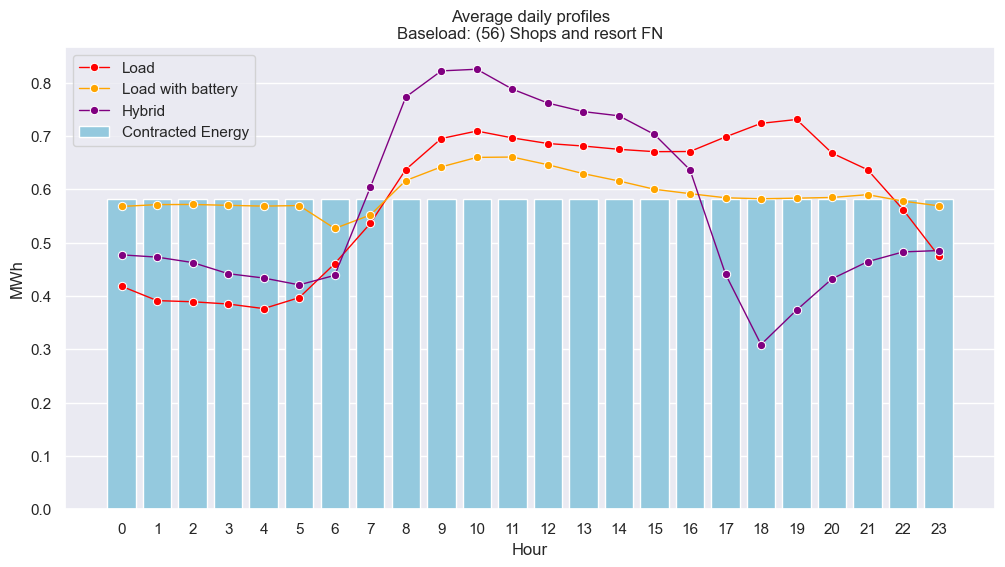

In [17]:
charts.plot_contract_samples(combined_data,input_collector,['Load', 'Load with battery'])

In [18]:
# Load Flex
flex_input_collector = user_inputs.launch_flex_input_collector()

Dropdown(description='Flexiblity rating:', options=('Very Low', 'Low', 'Medium', 'High', 'Very High'), value='…

FloatText(value=0.0, description='Raise price ($/MWh):')

FloatText(value=0.0, description='Lower price ($/MWh):')

FloatText(value=0.01, description='Ramp up penalty ($/MWh):')

FloatText(value=0.01, description='Ramp down penalty ($/MWh):')

In [19]:
combined_data = helper_functions.get_weekends(combined_data, input_collector['load_region'].value)

In [20]:
flex_rating = flex_input_collector['flex_rating'].value
raise_price = flex_input_collector['raise_price'].value
lower_price = flex_input_collector['lower_price'].value
ramp_up = flex_input_collector['ramp_up'].value
ramp_down = flex_input_collector['ramp_down'].value

with_load_flex = load_flex.daily_load_shifting(
    df=combined_data,
    flexibility_rating=flex_rating,
    load_region=load_region,
    raise_price=raise_price,
    lower_price=lower_price,
    ramp_up_price=ramp_up,
    ramp_down_price=ramp_down
)

combined_data['Load with flex'] = with_load_flex['Load with flex'].copy()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05

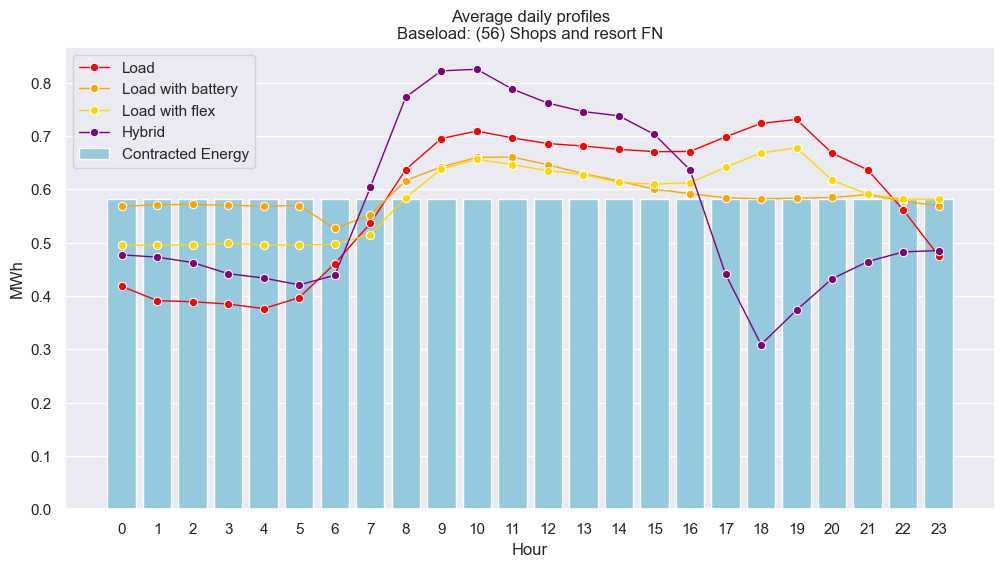

In [21]:
charts.plot_contract_samples(combined_data,input_collector,['Load', 'Load with battery', 'Load with flex'])

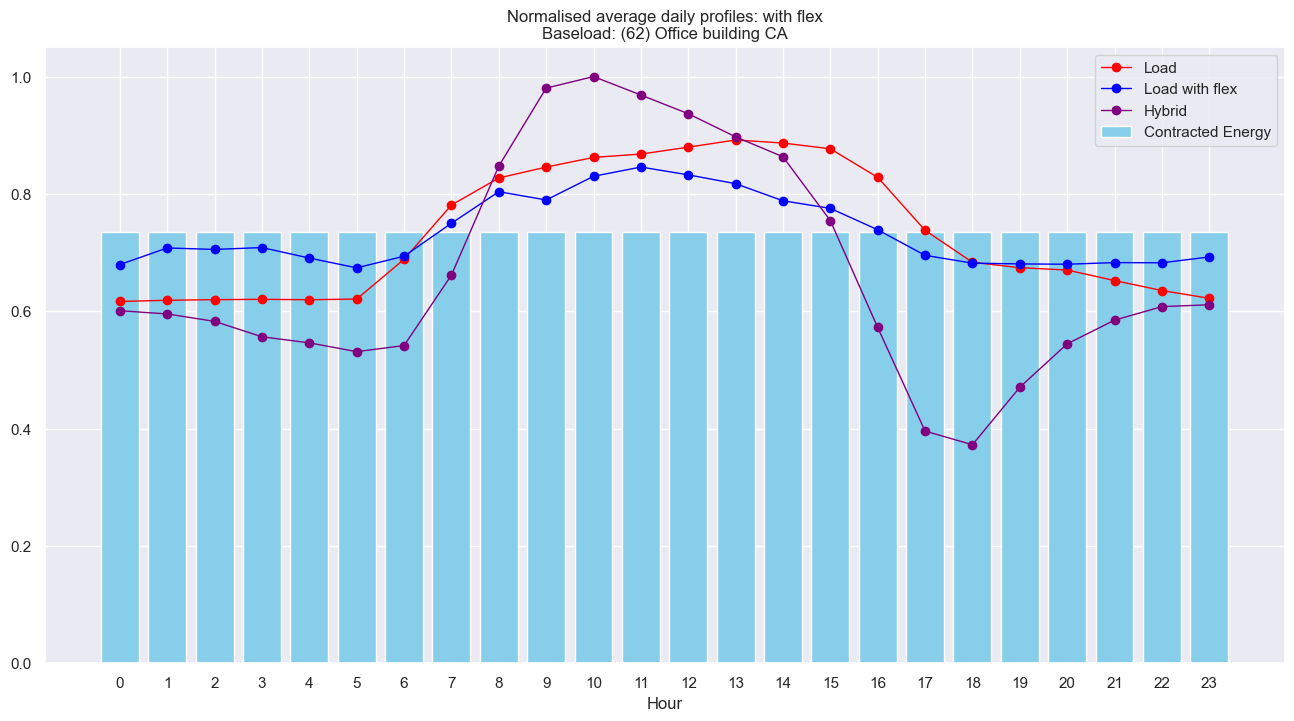

In [23]:
# Chart for hybrid, load and contracted energy:
to_plot = combined_data[['Load', 'Load with flex', 'Hybrid', 'Contracted Energy']].copy()
avg_day_to_plot = to_plot.groupby(to_plot.index.hour).mean(numeric_only=True)
avg_day_to_plot.index.name = 'Hour'

avg_day_to_plot = avg_day_to_plot/avg_day_to_plot.max().max()

# fig, ax = plt.subplots(figsize=(16,8))
# fig = sns.lineplot(data=avg_day_to_plot)
# plt.show()

plt.figure(figsize=(16,8))
# Plot bars
plt.bar(avg_day_to_plot.index, avg_day_to_plot['Contracted Energy'], color='skyblue', label='Contracted Energy')
# Plot lines
plt.plot(avg_day_to_plot.index, avg_day_to_plot['Load'], marker='o', color='red', linewidth=1, label='Load')
plt.plot(avg_day_to_plot.index, avg_day_to_plot['Load with flex'], marker='o', color='blue', linewidth=1, label='Load with flex')
plt.plot(avg_day_to_plot.index, avg_day_to_plot['Hybrid'], marker='o', color='purple', linewidth=1, label='Hybrid')

# Adding labels and title
plt.xticks(list(range(0,24)))
plt.xlabel('Hour')
plt.ylabel('')
plt.title(f'Normalised average daily profiles: with flex\n{contract_type}: {load_name}')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

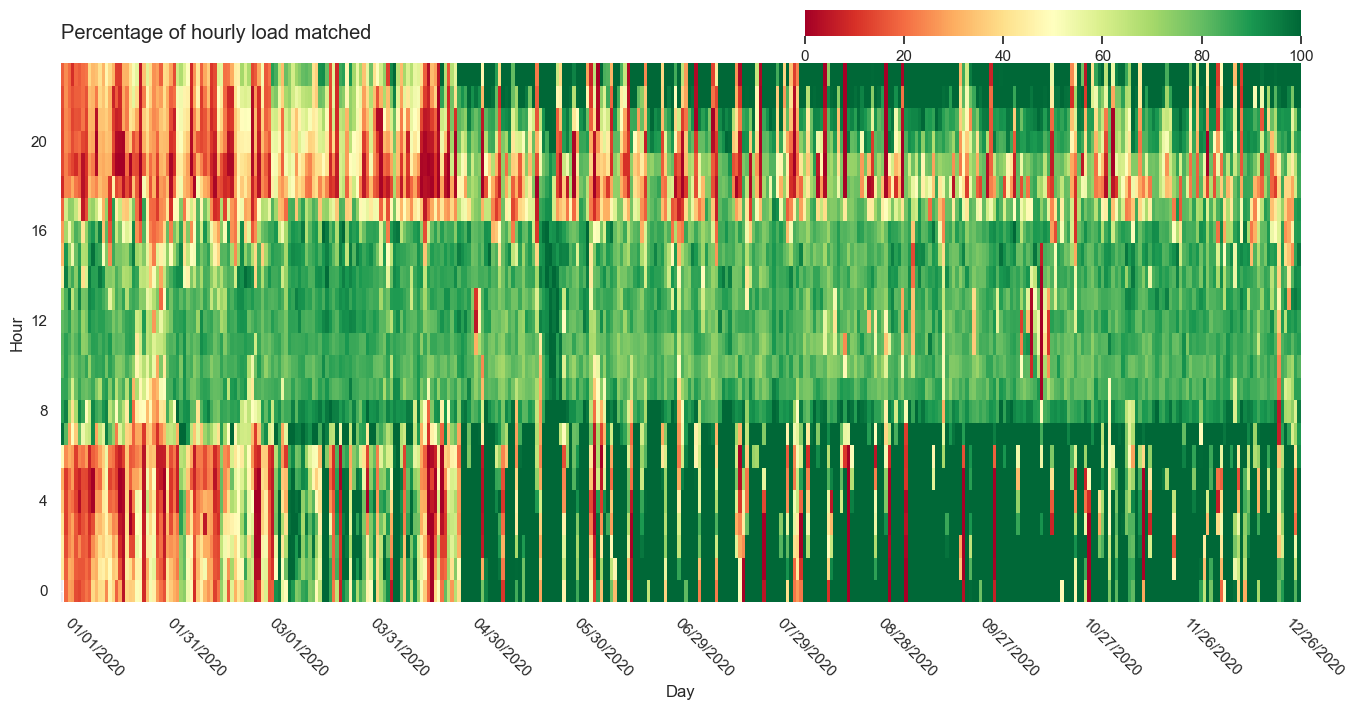

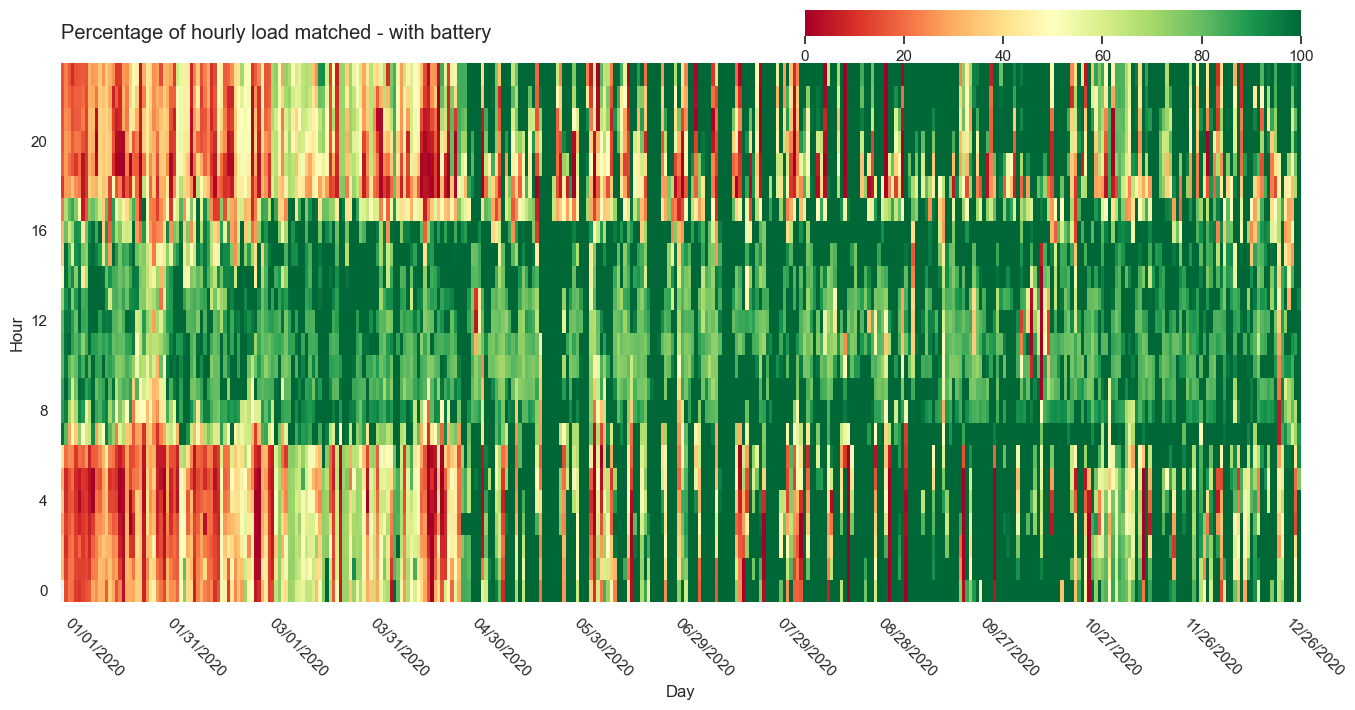

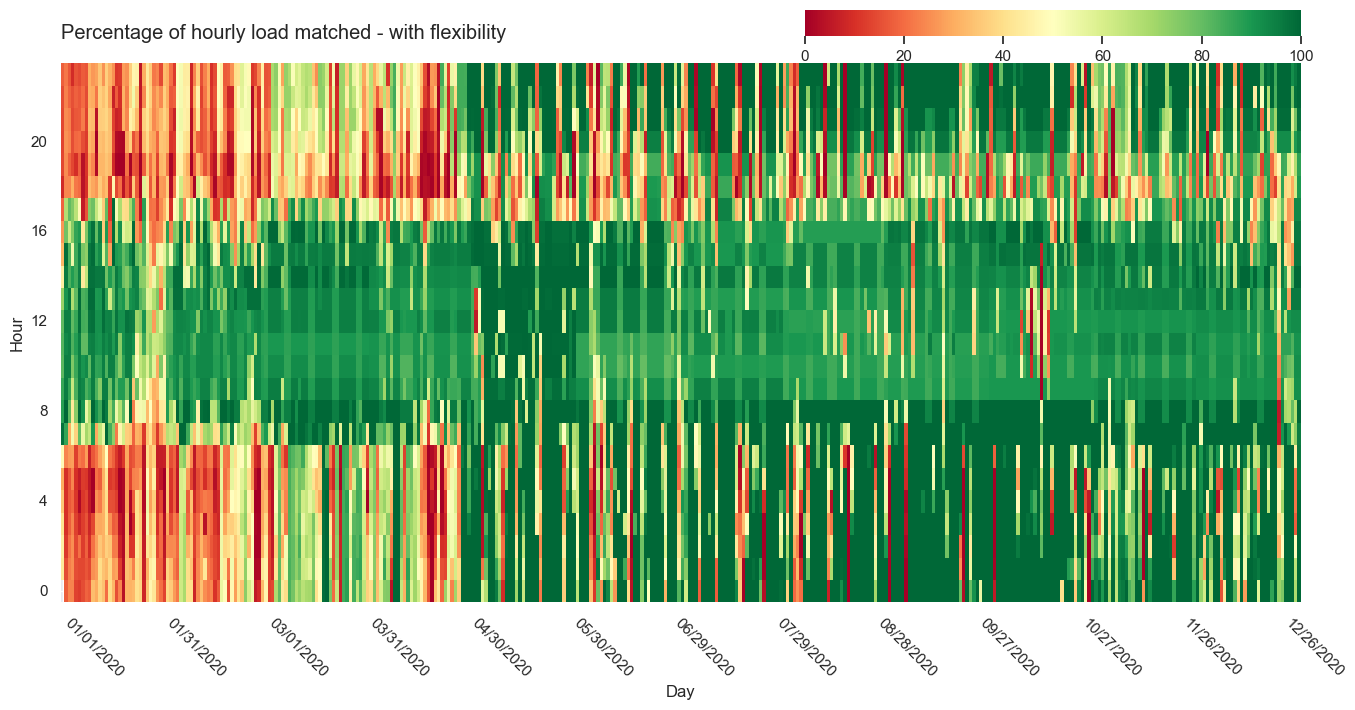

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 

matching = combined_data.copy()
matching['Delivered Hybrid'] = np.minimum(matching['Hybrid'], matching['Contracted Energy'])
matching['Hourly match (%)'] = np.where(matching['Load'] == 0, 100, np.minimum(matching['Delivered Hybrid'] / matching['Load'] * 100, 100))

matching_results_df = pd.DataFrame(matching['Hourly match (%)'])
matching_results_df['Hour'] = matching_results_df.index.hour
matching_results_df['Day'] = matching_results_df.index.strftime('%m/%d/%Y')
matching_results_df = matching_results_df.reset_index(drop=True)

matching_results_df = matching_results_df.pivot(index='Hour', columns='Day', values='Hourly match (%)')

fig, ax = plt.subplots(figsize=(16, 7))
colorbar_axes = inset_axes(
    ax,
    width = '40%',
    height = '5%',
    loc = 'upper right',
    bbox_to_anchor=(0, 0.1, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
ax = sns.heatmap(
    matching_results_df, 
    ax=ax, 
    cmap='RdYlGn', 
    cbar_ax=colorbar_axes, 
    cbar_kws={'orientation': 'horizontal'},
    yticklabels = 4,
    xticklabels=30
)
ax.invert_yaxis()
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
fig.suptitle(f'Percentage of hourly load matched', x=0.125, y=0.91, ha = 'left', va = 'bottom')
plt.show()



matching_results_df = combined_data.copy()
matching_results_df['Delivered Hybrid'] = np.minimum(matching_results_df['Hybrid'], matching_results_df['Contracted Energy'])

matching_results_df['Hourly match (%)'] = np.where(matching_results_df['Load with battery'] == 0, 100, np.minimum(matching_results_df['Delivered Hybrid'] / matching_results_df['Load with battery'] * 100, 100))
matching_results_df = pd.DataFrame(matching_results_df['Hourly match (%)'])
matching_results_df['Hour'] = matching_results_df.index.hour
matching_results_df['Day'] = matching_results_df.index.strftime('%m/%d/%Y')
matching_results_df = matching_results_df.reset_index(drop=True)
matching_results_df = matching_results_df.pivot(index='Hour', columns='Day', values='Hourly match (%)')
fig, ax = plt.subplots(figsize=(16, 7))
colorbar_axes = inset_axes(
    ax,
    width = '40%',
    height = '5%',
    loc = 'upper right',
    bbox_to_anchor=(0, 0.1, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
ax = sns.heatmap(
    matching_results_df, 
    ax=ax, 
    cmap='RdYlGn', 
    cbar_ax=colorbar_axes, 
    cbar_kws={'orientation': 'horizontal'},
    yticklabels = 4,
    xticklabels=30
)
ax.invert_yaxis()
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
fig.suptitle(f'Percentage of hourly load matched - with battery', x=0.125, y=0.91, ha = 'left', va = 'bottom')
plt.show()



matching_results_df = combined_data.copy()
matching_results_df['Delivered Hybrid'] = np.minimum(matching_results_df['Hybrid'], matching_results_df['Contracted Energy'])

matching_results_df['Hourly match (%)'] = np.where(matching_results_df['Load with flex'] == 0, 100, np.minimum(matching_results_df['Delivered Hybrid'] / matching_results_df['Load with flex'] * 100, 100))
matching_results_df = pd.DataFrame(matching_results_df['Hourly match (%)'])
matching_results_df['Hour'] = matching_results_df.index.hour
matching_results_df['Day'] = matching_results_df.index.strftime('%m/%d/%Y')
matching_results_df = matching_results_df.reset_index(drop=True)
matching_results_df = matching_results_df.pivot(index='Hour', columns='Day', values='Hourly match (%)')

fig, ax = plt.subplots(figsize=(16, 7))
colorbar_axes = inset_axes(
    ax,
    width = '40%',
    height = '5%',
    loc = 'upper right',
    bbox_to_anchor=(0, 0.1, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

ax = sns.heatmap(
    matching_results_df, 
    ax=ax, 
    cmap='RdYlGn', 
    cbar_ax=colorbar_axes, 
    cbar_kws={'orientation': 'horizontal'},
    yticklabels = 4,
    xticklabels=30
)

ax.invert_yaxis()
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

fig.suptitle(f'Percentage of hourly load matched - with flexibility', x=0.125, y=0.91, ha = 'left', va = 'bottom')
plt.show()

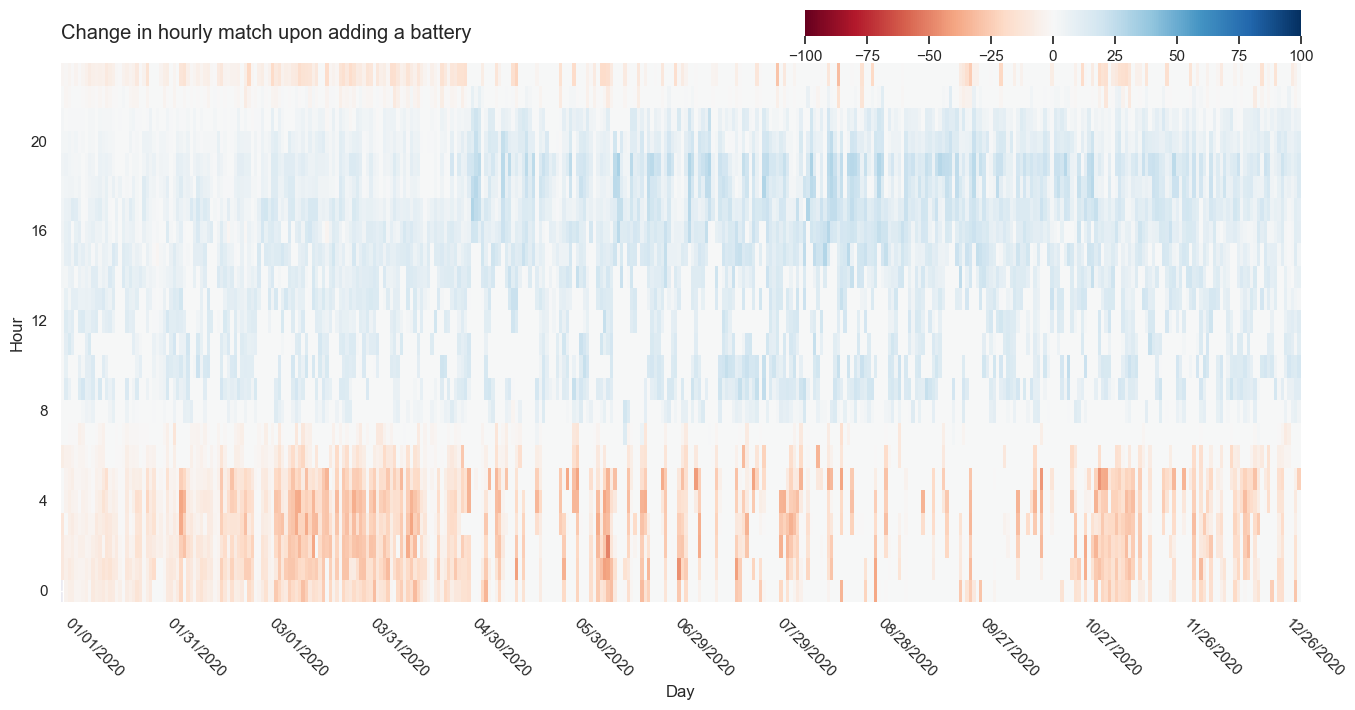

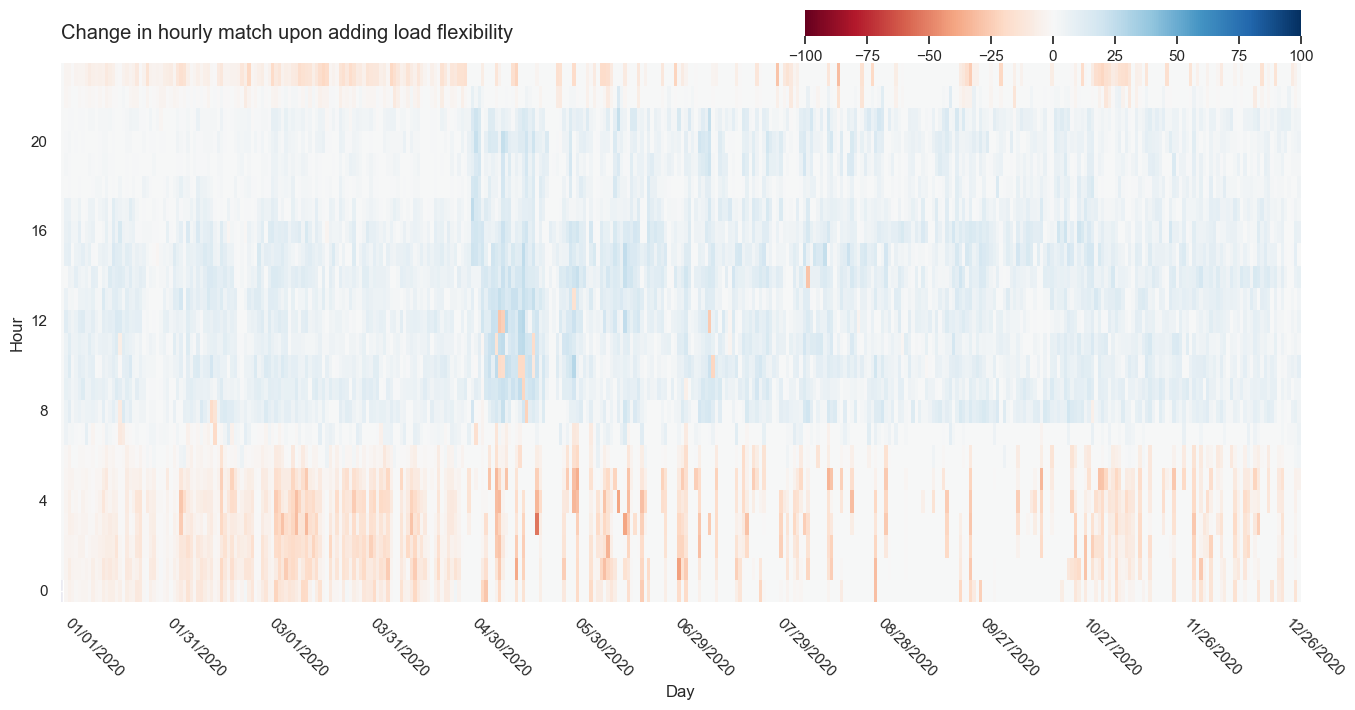

In [25]:
matching = combined_data.copy()
matching['Delivered Hybrid'] = np.minimum(matching['Hybrid'], matching['Contracted Energy'])
matching['Hourly match (%)'] = np.where(matching['Load'] == 0, 100, np.minimum(matching['Delivered Hybrid'] / matching['Load'] * 100, 100))
matching['Hourly match battery (%)'] = np.where(matching['Load with battery'] == 0, 100, np.minimum(matching['Delivered Hybrid'] / matching['Load with battery'] * 100, 100))
matching['Hourly match flex (%)'] = np.where(matching['Load with flex'] == 0, 100, np.minimum(matching['Delivered Hybrid'] / matching['Load with flex'] * 100, 100))

matching['Diff with battery (%)'] = matching['Hourly match battery (%)'] - matching['Hourly match (%)']
matching['Diff with flex (%)'] = matching['Hourly match flex (%)'] - matching['Hourly match (%)']


matching_results_df = pd.DataFrame(matching['Diff with battery (%)'])
matching_results_df['Hour'] = matching_results_df.index.hour
matching_results_df['Day'] = matching_results_df.index.strftime('%m/%d/%Y')
matching_results_df = matching_results_df.reset_index(drop=True)

matching_results_df = matching_results_df.pivot(index='Hour', columns='Day', values='Diff with battery (%)')
fig, ax = plt.subplots(figsize=(16, 7))
colorbar_axes = inset_axes(
    ax,
    width = '40%',
    height = '5%',
    loc = 'upper right',
    bbox_to_anchor=(0, 0.1, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
ax = sns.heatmap(
    matching_results_df, 
    ax=ax, 
    cmap='RdBu', 
    cbar_ax=colorbar_axes, 
    cbar_kws={'orientation': 'horizontal'},
    yticklabels = 4,
    xticklabels=30,
    vmin=-100,
    vmax=100
)
ax.invert_yaxis()
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
fig.suptitle(f'Change in hourly match upon adding a battery', x=0.125, y=0.91, ha = 'left', va = 'bottom')
plt.show()



matching_results_df = pd.DataFrame(matching['Diff with flex (%)'])
matching_results_df['Hour'] = matching_results_df.index.hour
matching_results_df['Day'] = matching_results_df.index.strftime('%m/%d/%Y')
matching_results_df = matching_results_df.reset_index(drop=True)

matching_results_df = matching_results_df.pivot(index='Hour', columns='Day', values='Diff with flex (%)')
fig, ax = plt.subplots(figsize=(16, 7))
colorbar_axes = inset_axes(
    ax,
    width = '40%',
    height = '5%',
    loc = 'upper right',
    bbox_to_anchor=(0, 0.1, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
ax = sns.heatmap(
    matching_results_df, 
    ax=ax, 
    cmap='RdBu', 
    cbar_ax=colorbar_axes, 
    cbar_kws={'orientation': 'horizontal'},
    yticklabels = 4,
    xticklabels=30,
    vmin=-100,
    vmax=100
)
ax.invert_yaxis()
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
fig.suptitle(f'Change in hourly match upon adding load flexibility', x=0.125, y=0.91, ha = 'left', va = 'bottom')
plt.show()

In [ ]:
test = {
    'CustomerType': 'Commercial',
    'Date_accessed': '2024-02',
    'Distributor': 'Ergon',
    'Name': 'EDSTT2 Demand Small East',
    'Parameters': {
        'Daily': {
            'Unit': '$/Day', 'Value': 8.0
        },
        'Demand': {
            'Anytime Demand': {
                'Min Demand (kW)': 35.0,
                'Month': [
                    1,2,3,4,5,6,7,8,9,10,11,12
                ],
                'TimeIntervals': {
                    'T1': ['00:00:00','00:00:00']
                },
                'Unit': '$/kW/day',
                'Value': 0.867,
                'Weekday': True,
                'Weekend': True
            },
            'Peak': {
                'Based on Network Peak': False,
                'Day Average': False,
                'Demand Window Length': 1,
                'Min Demand (kW)': 0,
                'Min Demand Charge ($)': 0,
                'Month': [
                    1,2,3,4,5,6,7,8,9,10,11,12
                ],
                'Number of Peaks': 1,
                'TimeIntervals': {
                    'T1': ['00:00', '24:00']
                },
                'Unit': '$/kW/Day',
                'Value': 0.0,
                'Weekday': True,
                'Weekend': True
            }
        },
        'Fixed': {'Unit': '$/Bill', 'Value': 0.0},
        'FlatRate': {'Unit': '$/kWh', 'Value': 0.5}
    },
    'ProviderType': 'Retailer',
    'State': 'QLD',
    'Tariff ID': 'TCER09',
    'Type': 'Demand',
    'Year': '2024'
}